## <a href="https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b#:%E2%80%94:text=to%20this%20story%2C-,An%20End%2Dto%2DEnd%20Project%20on%20Time%20Series,Analysis%20%20and%20Forecasting%20with%20Python&text=Time%20series%20analysis%2%20Ocomprises%20methods,other%20characteristics%20of%20the%20data." target="_blank">Artigo</a><br>
Livro: Practical Machine Learning with Python, pg 474 -> exemplo de predição de série temp. com ARIMA

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

In [2]:
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 13
matplotlib.rcParams['ytick.labelsize'] = 13
matplotlib.rcParams['text.color'] = 'k'

## Tratamento de dados

* Importar dados do arquivo
* Criar novo dataset onde os dados pertencem apenas à categoria "Furniture"

Obs: definir a variável "furniture" como um novo DataFrame, ao invés de 
continuar usando-a como um *slice* de "df" evita erros de [*chained indexing*](https://paulovasconcellos.com.br/o-que-%C3%A9-a-value-is-trying-to-be-set-on-a-copy-of-a-slice-from-a-dataframe-e85f744d8be1)

In [3]:
df = pd.read_excel("Superstore.xls")
furniture = pd.DataFrame(df.loc[df['Category'] == 'Furniture'])

In [4]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

In [5]:
furniture.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2121 entries, 0 to 9990
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         2121 non-null   int64         
 1   Order ID       2121 non-null   object        
 2   Order Date     2121 non-null   datetime64[ns]
 3   Ship Date      2121 non-null   datetime64[ns]
 4   Ship Mode      2121 non-null   object        
 5   Customer ID    2121 non-null   object        
 6   Customer Name  2121 non-null   object        
 7   Segment        2121 non-null   object        
 8   Country        2121 non-null   object        
 9   City           2121 non-null   object        
 10  State          2121 non-null   object        
 11  Postal Code    2121 non-null   int64         
 12  Region         2121 non-null   object        
 13  Product ID     2121 non-null   object        
 14  Category       2121 non-null   object        
 15  Sub-Category   2121 n

In [6]:
furniture.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


Colunas com dados que não serão importantes para a análise da série temporal, serão removidas.

In [7]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)

In [8]:
furniture.head()

,Order Date,Sales
0,2016-11-08,261.9600
1,2016-11-08,731.9400
3,2015-10-11,957.5775
5,2014-06-09,48.8600
10,2014-06-09,1706.1840


Verificar se existem valores *null* no dataset

In [9]:
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

Os valores serão ordenados de acordo com a "Order Date".

In [10]:
furniture = furniture.sort_values('Order Date')

Como os dados inicialmente não estavam ordenados por data, os índices ficaram desordenados, sendo necessário resetar o índice. <br>
Além disso os dados serão agrupados por data (somar os valores de "Sales" de uma mesma data e registrar numa única linha, eliminando repetições da coluna "Order Date").

In [11]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [12]:
furniture.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


In [13]:
furniture = furniture.set_index('Order Date')

In [14]:
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

"Os dados de data podem ser difíceis de trabalha, portanto, usaremos o valor médio das vendas diárias para aquele mês, e usaremos o início de cada mês como representação de data"<br>
A função ```.resample``` redimensiona o time series, *'MS'*, significa *month start*, ou seja, será usado o começo do mês como nova data, e utiliza-se o método ```.mean()``` para obter a média do mês.

In [15]:
y = furniture['Sales'].resample('MS').mean()

In [16]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

<AxesSubplot:xlabel='Order Date'>

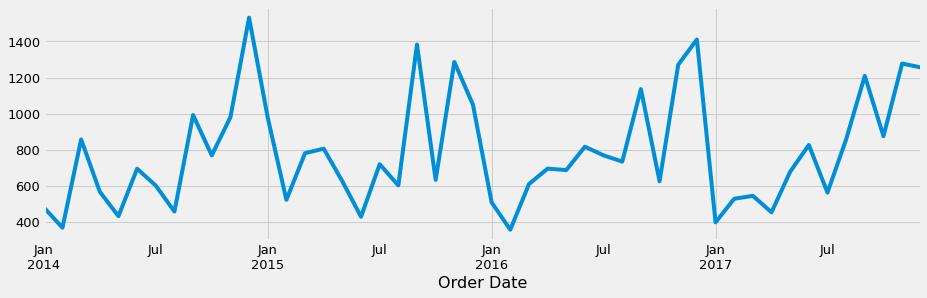

In [17]:
y.plot(figsize=(14,4))

Observa-se um certo padrão de aumento nas vendas nos meses finais do ano, com uma grande queda no início de um novo ano. As vendas variam um pouco ao longo dos primeiro semestre do do ano, voltando a crescer rapidamente no segundo semestre. 
___

## Decomposição de séries temporais
>" Uma decomposição clássica de séries temporais permite que a série seja escrita como uma soma ou multiplicação de componentes não observáveis. Assim, pode-se usar um modelo aditivo – quando se  supõe  que  os  componentes  da  série  temporal  são  somados  para  formar  os  dados – ou  um  modelo multiplicativo – que  supõe  que  os  componentes  são  multiplicados  um  pelo  outro."

* **Tendência:** As grandezas, em boa parte das vezes, apresentam uma tendência de comportamento em relação à  variável  tempo. Assim,  nesses  casos,  elas  revelam  um  comportamento  que tende a  ser  maior  (na maioria  das  vezes)   ou   menor  à   medida  que   o  tempo  passa.Essa  tendência,  normalmente,   é consequência do aumento da população e/ou da evolução tecnológica/científica, mas também pode ser fruto de outras causas, como o aumento gradativo da temperatura na Terra ou até mesmo de mudanças no comportamento cultural das sociedades.

* **Sazonalidade:** Explica  o  comportamento  cíclico  (ao  longo  de  um  ano  ou  intervalo  menor)  das  grandezas, muitas  vezes,sendo resultado de suas  variações  em função das  estações  do ano (por  exemplo: venda de  sorvetes,  consumo  de  energia  elétrica).  Nesses  casos,  o  padrão  de  sazonalidade  é  mensal  ou trimestral  ao  longo  do  ano. 

* **Resíduo (Componentes aleatórios):** Se  expurgarmos  os  efeitos  sazonais,  cíclicos  e  de  tendência  de  uma  série  que  revele  o comportamento  de  uma  grandeza  ao  longo  do  tempo,  o  restante  da  sua  variação  é  chamada  de flutuação residual e pode ser considerada como proveniente de componentes aleatórios. Essa flutuação residual também pode ser entendida como oriunda de situações indistinguíveis, já que a sazonalidade, a tendência e o ciclo foram encarados como situações distinguíveis.

[Ref 1](http://www.anpad.org.br/periodicos/arq_pdf/a_1320.pdf) | [Ref 2](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/)

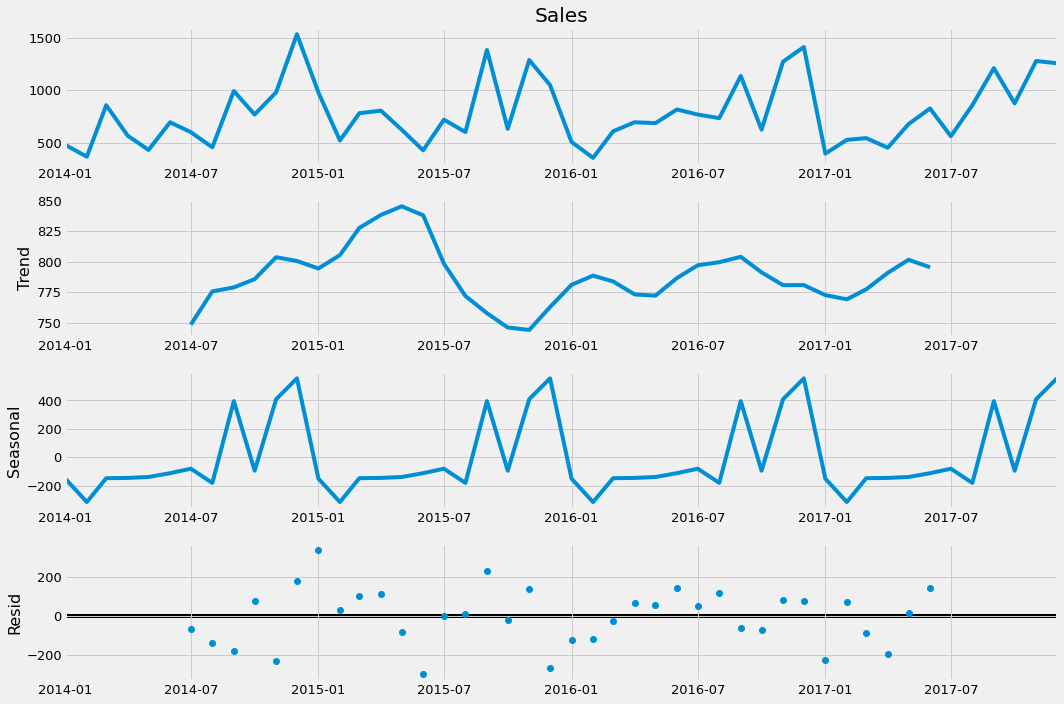

In [18]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

Oberva-se que no longo prazo não há uma **tendência** clara nos dados, e existe uma instabilidade quanto ao crescimendo.<br>
Já a **sazonalidade** é bastante óbvia, com um grande aumento nas vendas no período final de cada ano, e então uma queda brusca no início do próximo ano.
____

## Predição de séries temporais com ARIMA

> ARIMA= AutoRegressive Integrated Moving Average (modelo auto-regressivo integrado de médias móveis)

A parte auto-regressiva (AR) do modelo ARIMA indica que a variável evoluinte de interesse é regressada em seus próprios valores defasados, isto é, anteriores. A parte de média móvel (MA) indica que o erro de regressão é na verdade uma combinação linear dos termos de erro, cujos valores ocorreram contemporaneamente e em vários momentos no passado. A parte integrada (I) indica que os valores de dados foram substituídos com a diferença entre seus valores e os valores anteriores e este processo diferenciador pode ter sido realizado mais de uma vez. O propósito da cada uma destas características é fazer o modelo se ajustar aos dados da melhor forma possível.

Uma série temporal não exibe padrões sazonais e não seja apenas ruído aleatório, pode ser modelada com um modelo ARIMA, representado como ARIMA(p,d,q), sendo os termos:

* **p** é a ordem do termo Auto-Regressivo (AR), e se refere ao número de termos defasados (anteriores) de Y que serão usados como preditores.
* **d** é a ordem de diferenciação, indicando quantas vezes os dados tiveram valores passados subtraídos, ou seja, o número de diferenciações necessárias para fazer a série temporal estacionária.
* **q** é a ordem do termo de Média Móvel (MA), e se refere ao número de erros defasados que são utilizados na previsão

Se a série temporal tem um padrão sazonal, então é necessário adicionar termos sazionais ao modelo, que se torna um modelo SARIMA (Seasonal ARIMA).Modelos ARIMA sazonais são geralmente denotados como ARIMA(*p, d, q*)(*P, D, Q*)<sub>*m*</sub>, em que *m* se refere ao número de períodos em cada temporada e *P, D e Q* se referem aos termos de auto-regressão, diferenciação e média móvel para a parte sazonal do modelo ARIMA.

Para avaliar o desempenho dos parâmetros, observa-se o AIC (Akaike Information Critera), que quantifica o quão bom foi o ajuste e a simplicidade do modelo, num único valor. Normalmente, o melhor conjunto de parâmetros apresenta o menor valor de AIC.

ARIMA: [Ref 1](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/) | [Ref 2](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/) | [Ref 3](https://pt.wikipedia.org/wiki/ARIMA)<br>
AIC: [Ref 4](https://coolstatsblog.com/2013/08/14/using-aic-to-test-arima-models-2/) | [Ref 5](https://en.wikipedia.org/wiki/Akaike_information_criterion)





In [19]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

log=pd.DataFrame(columns=['Param','SParam','AIC'])

warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod=sm.tsa.statespace.SARIMAX(y,
                                          order=param,
                                          seasonal_order=param_seasonal,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
            results = mod.fit()
            log=log.append(pd.Series([param, param_seasonal, results.aic],index=log.columns), ignore_index=True)
            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
best=log[log['AIC']==log['AIC'].min()]
print('O menor AIC foi obtido em:\nARIMA{}x{} com AIC={:.3f}'.format(best.iloc[-1]['Param'],best.iloc[-1]['SParam'],best.iloc[-1]['AIC']))

warnings.filterwarnings("default")

O menor AIC foi obtido em:
ARIMA(0, 1, 1)x(0, 1, 1, 12) com AIC=279.581


* **Modelo do artigo**

Mesmo usando os mesmos dados e mesmo conjunto de parâmetros, ainda houveram diferenças entre os resultados aqui e os apresentados no artigo (gráfico de diagnostico, tabela de resultados, a própria predição).

In [20]:
mod1 = sm.tsa.statespace.SARIMAX(y,
                               order=(1,1,1),
                               seasonal_order=(1,1,0,12),
                               enforce_stationary=False,
                               enforce_invertibility=False)

results1 = mod1.fit()
print(results1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0676      0.226      0.299      0.765      -0.376       0.511
ma.L1         -1.0000      0.279     -3.590      0.000      -1.546      -0.454
ar.S.L12      -0.4807      0.147     -3.260      0.001      -0.770      -0.192
sigma2      4.108e+04   6.78e-06   6.06e+09      0.000    4.11e+04    4.11e+04


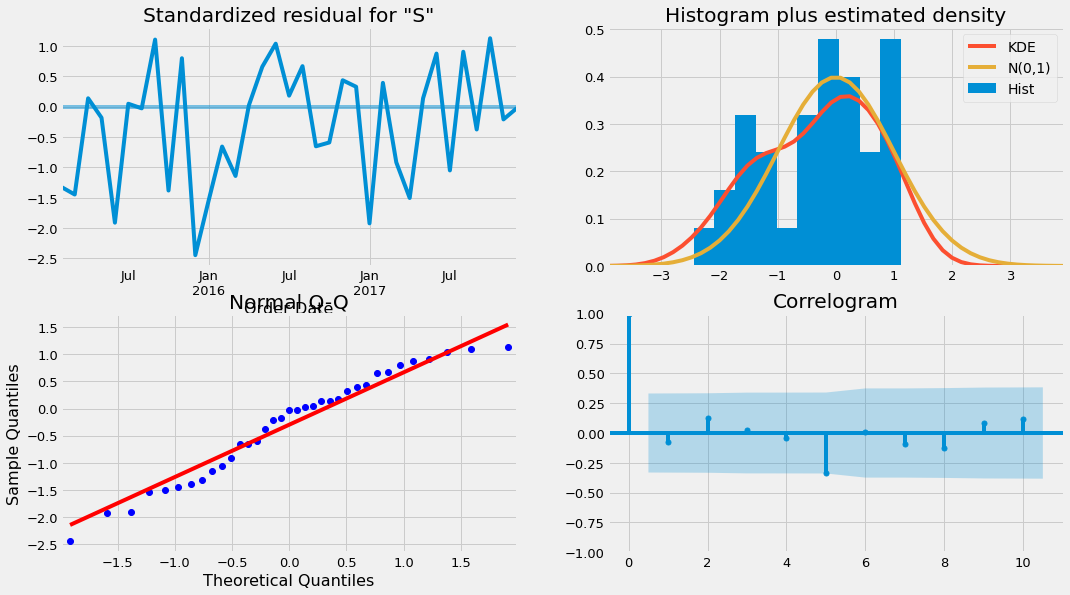

In [21]:
results1.plot_diagnostics(figsize=(16,9))
plt.show()

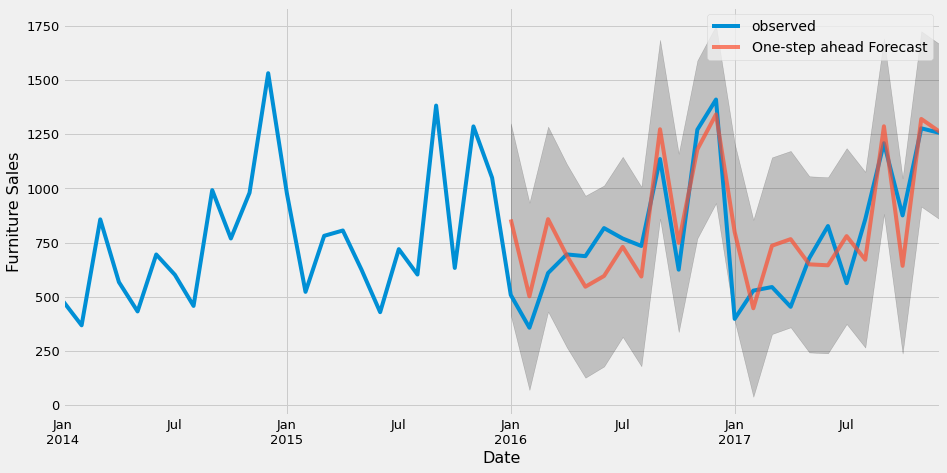

In [22]:
pred1 = results1.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred1_ci = pred1.conf_int()
ax = y['2014':].plot(label='observed')
pred1.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred1_ci.index,
                pred1_ci.iloc[:, 0],
                pred1_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

Meu modelo

In [23]:
mod2 = sm.tsa.statespace.SARIMAX(y,
                               order=(0,1,1),
                               seasonal_order=(0,1,1,12),
                               enforce_stationary=False,
                               enforce_invertibility=False)

results2 = mod2.fit()
print(results2.summary().tables[1])


e:\softwares\python3.6.8\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000   1060.496     -0.001      0.999   -2079.534    2077.534
ma.S.L12      -1.0001   1060.561     -0.001      0.999   -2079.662    2077.662
sigma2      2.686e+04      0.002   1.56e+07      0.000    2.69e+04    2.69e+04


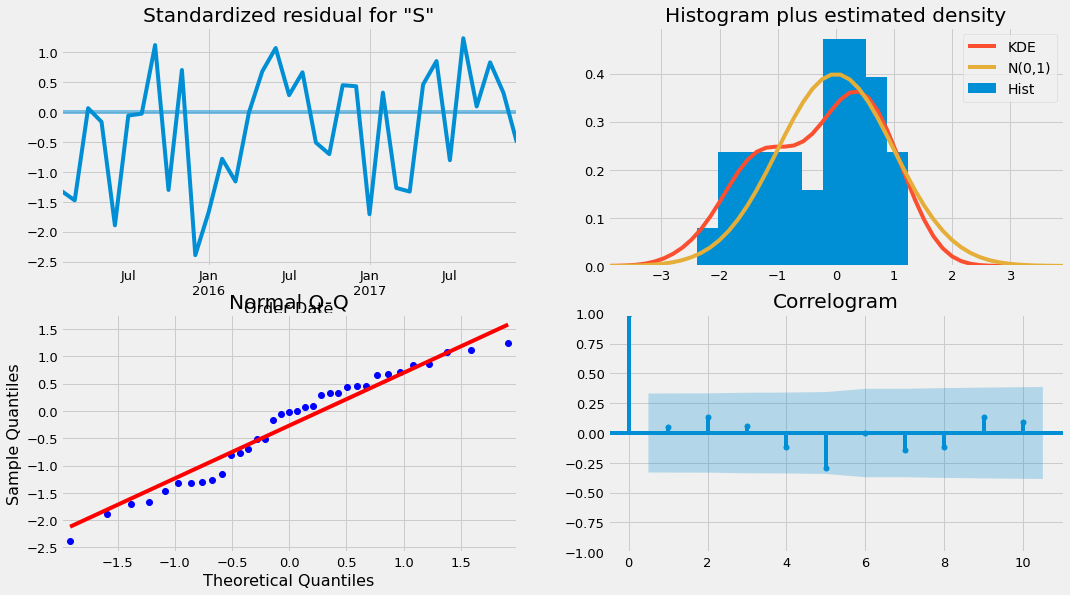

In [24]:
results2.plot_diagnostics(figsize=(16,9))
plt.show()

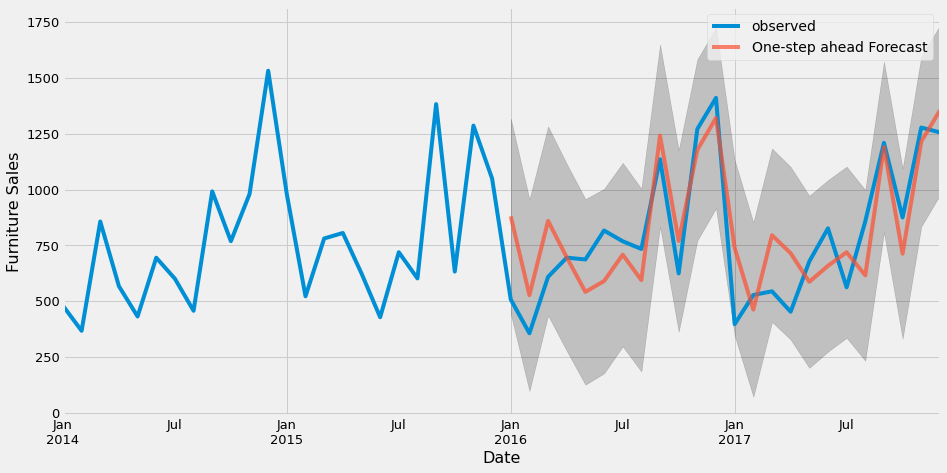

In [25]:
pred2 = results2.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred2_ci = pred2.conf_int()
ax = y['2014':].plot(label='observed')
pred2.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred2_ci.index,
                pred2_ci.iloc[:, 0],
                pred2_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

**Comparação de predição artigo original e conjunto selecionado**

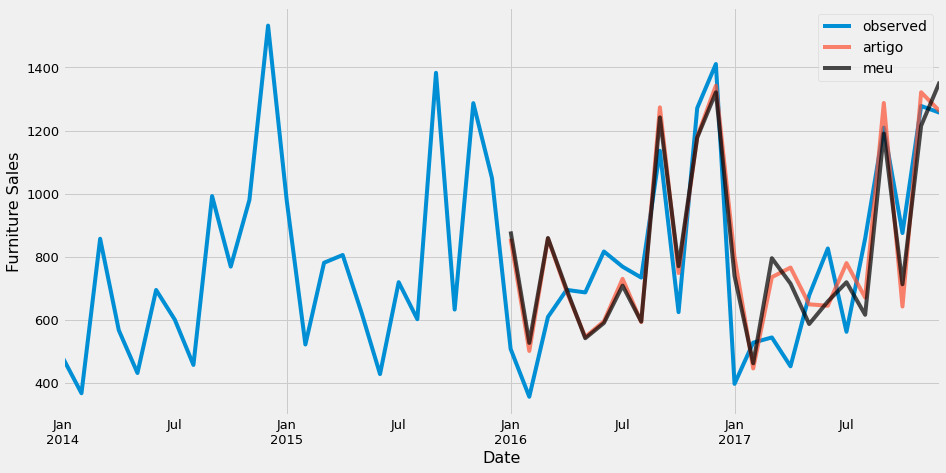

In [26]:
# mudança de 2017->2016

ax = y['2014':].plot(label='observed')
pred1.predicted_mean.plot(ax=ax, label='artigo', alpha=.7, figsize=(14, 7))
pred2.predicted_mean.plot(ax=ax, label='meu', alpha=.7, figsize=(14, 7),color='black')
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

Os dois modelos obtiveram desempenho praticamente igual na predição de 2016-2017. A diferença entre eles é maior no período 2017-2018. Porém, o modelo escolhido por mim, dispensa o termo de médias móveis tanto nos parâmetros do ARIMA quanto nos parâmetros sazionais.<br>
Dessa forma, para continuar esse problema será usado o conjunto de parâmetros do artigo original, mas seria importante uma análise de outros conjuntos de parâmetros viáveis, que apresentem valores baixos de AIC.

In [27]:
log[log['AIC']<300]

,Param,SParam,AIC
11,"(0, 0, 1)","(0, 1, 1, 12)",291.626139
15,"(0, 0, 1)","(1, 1, 1, 12)",291.872558
27,"(0, 1, 1)","(0, 1, 1, 12)",279.580623
31,"(0, 1, 1)","(1, 1, 1, 12)",281.557662
43,"(1, 0, 1)","(0, 1, 1, 12)",293.342219
47,"(1, 0, 1)","(1, 1, 1, 12)",293.751319
59,"(1, 1, 1)","(0, 1, 1, 12)",281.387301
62,"(1, 1, 1)","(1, 1, 0, 12)",297.787544
63,"(1, 1, 1)","(1, 1, 1, 12)",283.366101


## Validação da predição

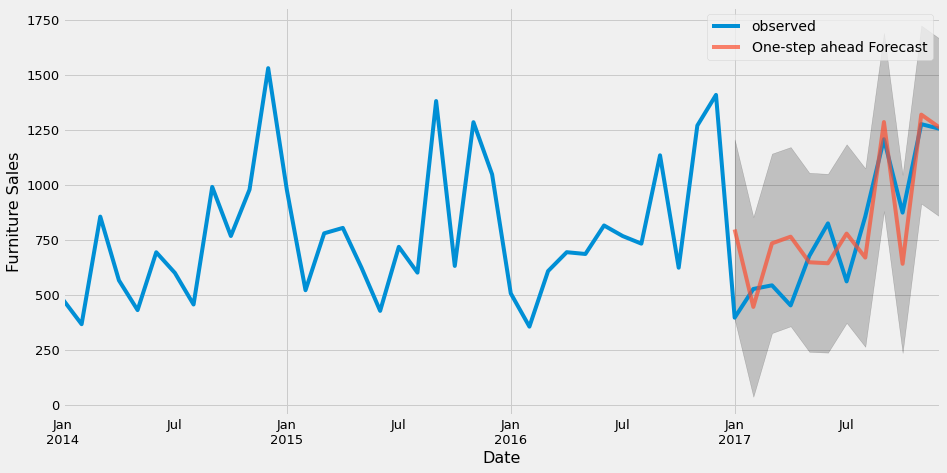

In [28]:
pred1 = results1.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred1_ci = pred1.conf_int()
ax = y['2014':].plot(label='observed')
pred1.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred1_ci.index,
                pred1_ci.iloc[:, 0],
                pred1_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [30]:
y_forecasted = pred1.predicted_mean
y_truth = y['2017-01-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
mae = (y_forecasted - y_truth).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
print('The Mean Absolute Error of our forecasts is {}'.format(round((mae), 2)))

The Mean Squared Error of our forecasts is 39996.01
The Root Mean Squared Error of our forecasts is 199.99
The Mean Absolute Error of our forecasts is 44.7


Estatisticamente, o Erro Médio Quadrado (MSE), é uma medida da qualidade do estimador, nunca é negativo e quão menor seja o valor, mais próxima a linha de melhor ajuste.<br>
~~A Raiz do MSE (RMSE) aponta que o modelo foi capaz de prever a média diária de vendas em aproximadamente 200 das vendas reais.~~<br>
A Raiz do MSE (RMSE) aponta que as predições estão, em média, dentro de uma faixa de 200 vendas para mais ou para menos, em relação aos dados verdadeiros. Considerando que geralmente são feitas de 400 a 1400 vendas por dia, por enquanto esse valor é "OK" para considerar o modelo com um bom ajuste.

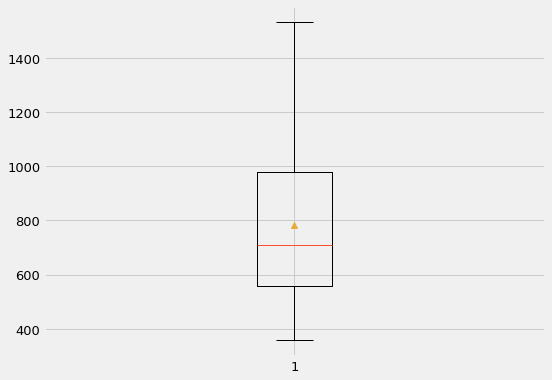

In [49]:
rcParams['figure.figsize'] = 8,6
plt.boxplot(y, showmeans=True);

## Produzindo e visualizando predições

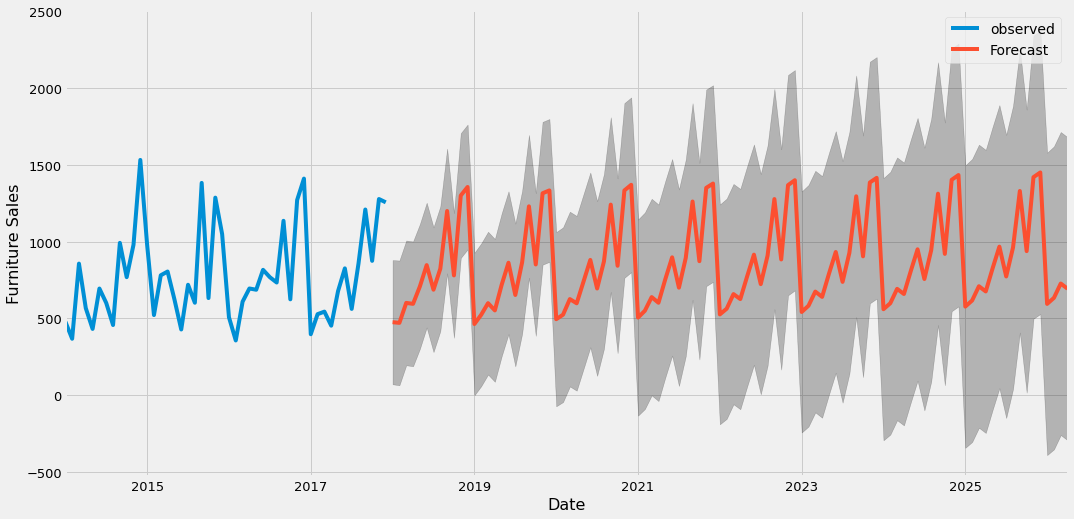

In [54]:
pred_uc = results1.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(16, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

O impacto da sazonalidade do modelo fica bem evidente, com o mesmo padrão se repetindo ao longo dos anos.

Quão mais a frente no futuro, menor será a confiança no modelo, o que é indicado pela região sombreada, a margem de confiança de predição.